# **Animal Competition (30%)**
For the non-competition mode, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals. 

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories. 

We provide a baseline by the following steps:


*   Loding and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 

The following trick/tweak(s) could be considered:

Please note that if you employ transfer learning, please conduct experiments on with and without pre-trained weights. Please try to turn the parameters (training parameters, augmentation, loss function...) after you change the network.


1. Transfer Learning
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.
6. Others

Your code should be modified from the provided baseline. A pdf report is required to explain the tricks you employed, and the imporvements they achieved.
Marking Rules:

We will mark the resykts based on the final test accuracy on testing images and your report.

Final mark = acc_mark + efficiency mark + report mark + bonus mark


We have two mark rules for acc and efficiency. You will get the higher one based on the results. For example, if you rank top 20%, but you only achieve 80% accuracy, you will get 10 points. If you rank 60%, but you get 95% accuracy, you will also get 10 points.


###Acc_mark 15:



|Accuracy|Mark|
|---|---|
| >95%|          10|
|>85%|         8|
|>75%  |        6|
|>65%  |      4|
|>55%  |      2|
|Not implemented| 0|


|Accuracy|Mark|
|---|---|
| Top 20% in the class|          10|
|20%-40%|         8|
|40%-60%  |        6|
| 60%-80%  |      4|
| 80%-100%  |      2|
|Not implemented| 0|




###Efficiency mark 5:

Efficiency is evaluated by the computational costs (flops: https://en.wikipedia.org/wiki/FLOPS). Please report the computational costs for your final model and attach the code/process about how you calculate it.

|Efficiency|Mark|
|---|---|
|<0.69G|          5|
|<1 G|         4|
|<5 G  |        3|
|<10 G |      2|
|<20 G  |      1|
|Not implemented| 0|


|Efficiency|Mark|
|---|---|
| Top 20% in the class|          5|
|20%-40%|         4|
|40%-60%  |        3|
| 60%-80%  |      2|
| 80%-100%  |      1|
|Not implemented| 0|



###Report mark 15:
1. Introduction and your understanding to the baseline model: 1 points

2.Detailed explainsations on the methods.: 5 points

Clearly explain the reference, motivation and design choice for each trick/tweak(s). Providing the experimental results in tables.
Example table:

|Trick1|Trick2|Trick3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

Observation and discussion based on the experiment results.

3. Expaination of the methods on reducing the computational cost and/or improve the trade-off between accuracy and efficiency: 3 points

4. Explaination of the code implementation：3 points

5. Visulization results: e.g. training and testing accuracy/loss for each model, faliure case studies: 2 points

6. Open ended:  Limitations, conclusions, failure cases analysis...: 1 points

###Bouns mark:
1. Top one result: 1 points
2. Fancy designs: 1 points



In [1]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name: Duc Nhan Do, Hong Phuc Pham
### Student ID: a123456, a654321
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 99.67%        FLOPs: 0.21G
##################################################################################################################################

In [ ]:
!pip install "ray[tune]"

In [3]:
from ray import tune
from functools import partial
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [4]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split, Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
from google.colab import drive
drive.mount('/content/drive')

## on Phuc's drive
%cd /content/drive/MyDrive/Notebooks/CV/A4 
## on Nhan's drive
#%cd /content/drive/MyDrive/A4/final

Mounted at /content/drive
/content/drive/MyDrive/Notebooks/CV/A4


In [6]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/Notebooks/CV/A4/dataset' ## on Phuc's drive
#data_dir = '/content/drive/MyDrive/A4/dataset' ## on Nhan's drive
classes = os.listdir(data_dir)

In [7]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
transform = transforms.Compose([
            transforms.Resize(112),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

augment_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(100),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


In [8]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=transforms.ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [9]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [10]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


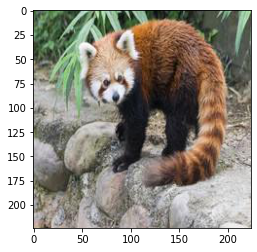

In [11]:
show_image(*dataset[200])

In [12]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [13]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)  

(5330, 313, 627)

In [14]:
class LoadDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x = dataset[index][0]
        if self.transform:
            x = self.transform(dataset[index][0])
            
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [15]:
train_ds = LoadDataset(train_ds, augment_transform)
val_ds = LoadDataset(val_ds, transform)
test_ds = LoadDataset(test_ds, transform)

In [16]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

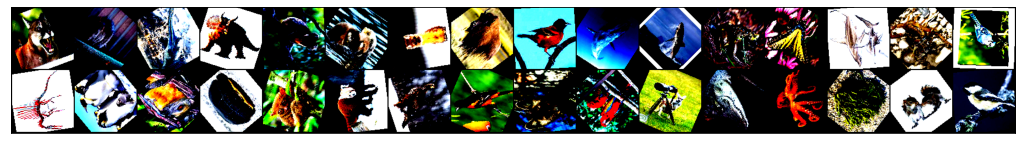

In [17]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

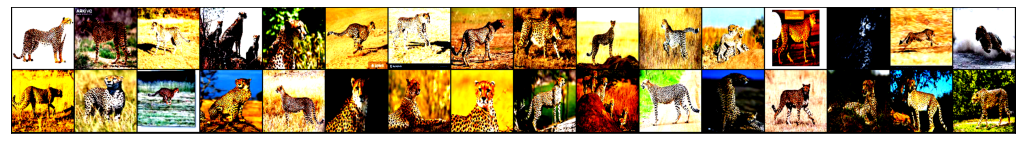

In [18]:
# Multiple images preview. 
for images, labels in val_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

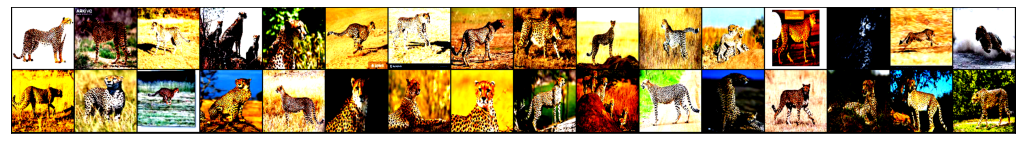

In [19]:
# Multiple images preview. 
for images, labels in test_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [20]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
 # To check wether Google Colab GPU has been assigned/not. 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

cuda


In [23]:
input_size = 3*112*112
output_size = 151

In [24]:
# Functions for evaluation and training.
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

### VGG16

In [26]:
# Transfer learning - VGG16
class TF_VGG16(ImageClassificationBase):
    def __init__(self, classes, vgg16):
        super().__init__()
        self.num_classes = classes
        self.features = vgg16.features
        self.fc1 = nn.Linear(512*3*3, 2048)
        self.fc2 = nn.Linear(2048, self.num_classes)

    def forward(self,X):
        X = self.features(X)
        X = X.view(X.size()[0], -1)
        X = self.fc1(X)
        x = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [27]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [28]:
# Freeze cnn blocks
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
# Model print
num_classes = 151
model_vgg16 = TF_VGG16(num_classes, vgg16)
model_vgg16.to(device)

In [30]:
# We can check the input and the output shape
for images, labels in train_dl:
    out = model_vgg16(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 112, 112])
out.shape: torch.Size([32, 2048])
out[0]: tensor([-7.1818, -7.6898, -8.3305,  ..., -9.4336, -8.3309, -9.7701],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [31]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
history = []
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

627


In [ ]:
history += fit(num_epochs, lr, model_vgg16, train_dl, val_dl, opt_func)

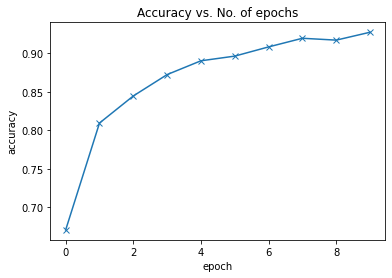

In [33]:
plot_accuracies(history)

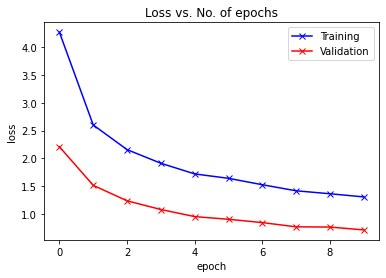

In [34]:
plot_losses(history)

In [35]:
evaluate(model_vgg16, test_loader)

{'val_acc': 0.9270620346069336, 'val_loss': 0.7138237357139587}

### Inception V3

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
# Freeze cnn blocks
for param in inception_v3.parameters():
    param.requires_grad = False

In [ ]:
# Transfer learning - InceptionV3
class TF_INCEPTIONV3(ImageClassificationBase):
    def __init__(self, classes, inception=None):
        super().__init__()
        self.num_classes = classes
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c
        self.avgpool = inception.avgpool
        self.dropout = inception.dropout
        num_ftrs = inception.fc.in_features
        self.fc = nn.Linear(num_ftrs, self.num_classes)

    def forward(self,x):
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
# Model print
num_classes = 151
model_inception = TF_INCEPTIONV3(num_classes, inception_v3)
model_inception.to(device)

In [ ]:
history = []
num_epochs = 10
opt_func = torch.optim.SGD ### change to Adam
lr = 0.0001

In [ ]:
history += fit(num_epochs, lr, model_inception, train_dl, val_dl, opt_func)

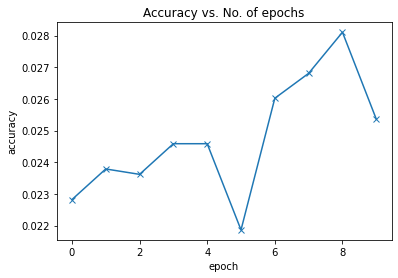

In [ ]:
plot_accuracies(history)

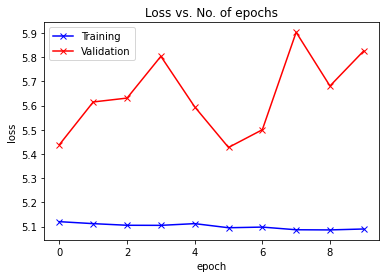

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model_inception, test_loader)

{'val_acc': 0.02536139450967312, 'val_loss': 5.826311111450195}

### ResNet 50

In [36]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [37]:
# Freeze cnn blocks
for param in resnet50.parameters():
    param.requires_grad = False

In [38]:
# Transfer learning - ResNet50
class TF_RESNET50(ImageClassificationBase):
    def __init__(self, classes, resnet=None):
        super().__init__()
        self.num_classes = classes
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, self.num_classes)

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
# Model print
num_classes = 151
model_resnet = TF_RESNET50(num_classes, resnet50)
model_resnet.to(device)

In [40]:
history = []
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history += fit(num_epochs, lr, model_resnet, train_dl, val_dl, opt_func)

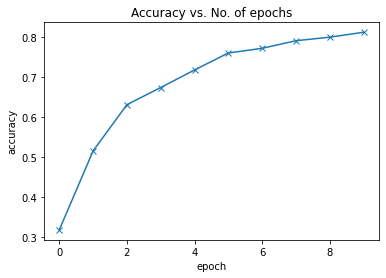

In [42]:
plot_accuracies(history)

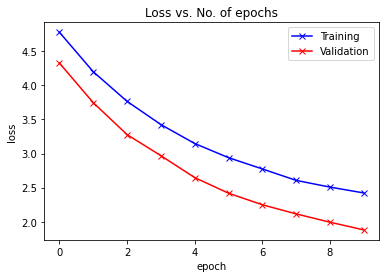

In [43]:
plot_losses(history)

In [44]:
evaluate(model_resnet, test_loader)

{'val_acc': 0.8120854496955872, 'val_loss': 1.8794909715652466}

### EfficientNet

In [ ]:
class TF_EFFICIENT_NET(ImageClassificationBase):
    def __init__(self, classes, effnet):
        super().__init__()
        self.num_classes = classes
        self.features = effnet.features
        self.avgpool = effnet.avgpool
        num_ftrs = list(effnet.classifier.children())[1].in_features
        self.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                        nn.Linear(num_ftrs, self.num_classes))

    def forward(self, X):
        X = self.features(X)
        X = self.avgpool(X)
        X = X.view(X.size()[0], -1)
        X = self.classifier(X)
        
        return F.log_softmax(X, dim=1)

#### EfficientNetB0

In [ ]:
efficient_b0 = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
# Freeze cnn blocks
for param in efficient_b0.parameters():
    param.requires_grad = False

In [ ]:
# Model print
num_classes = 151
model_efficient_b0 = TF_EFFICIENT_NET(num_classes, efficient_b0)
to_device(model_efficient_b0, device)

In [ ]:
history = []
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history += fit(num_epochs, lr, model_efficient_b0, train_dl, val_dl, opt_func)

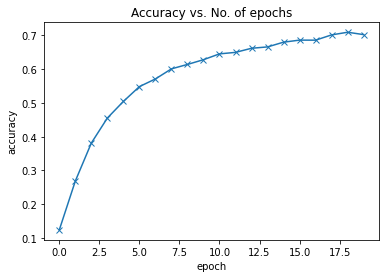

In [ ]:
plot_accuracies(history)

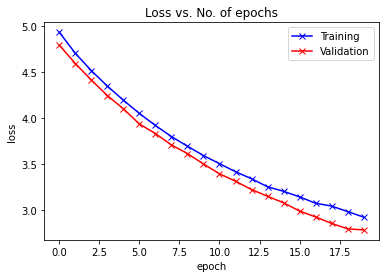

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model_efficient_b0, test_loader)

{'val_acc': 0.7018814086914062, 'val_loss': 2.784066915512085}

In [ ]:
# torch.save(model_efficient_b0.state_dict(), 'efficient_b0_weights(1).pth')

#### EfficientNetB7

In [ ]:
efficient_b7 = models.efficientnet_b7(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [ ]:
# Freeze cnn blocks
for param in efficient_b7.parameters():
    param.requires_grad = False

In [ ]:
# Model print
model_efficient_b7 = TF_EFFICIENT_NET(num_classes, efficient_b7)
model_efficient_b7.cuda()

In [ ]:
history = []
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history += fit(num_epochs, lr, model_efficient_b7, train_dl, val_dl, opt_func)

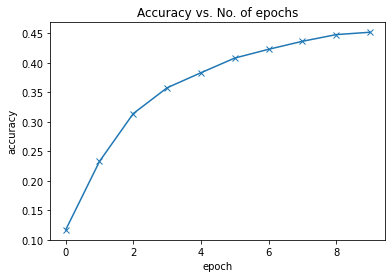

In [ ]:
plot_accuracies(history)

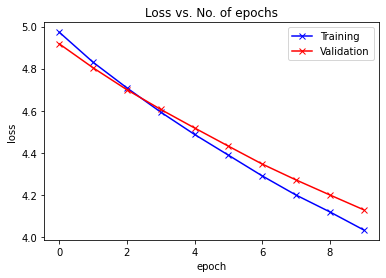

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model_efficient_b7, test_loader)

{'val_acc': 0.4518176019191742, 'val_loss': 4.12985897064209}

#### EfficientNetB1

In [ ]:
efficient_b1 = models.efficientnet_b1(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [ ]:
# Freeze cnn blocks
for param in efficient_b1.parameters():
    param.requires_grad = False

In [ ]:
# Model print
num_classes = 151
model_efficient_b1 = TF_EFFICIENT_NET(num_classes, efficient_b1)
model_efficient_b1.to(device)

In [ ]:
history = []
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history += fit(num_epochs, lr, model_efficient_b1, train_dl, val_dl, opt_func)

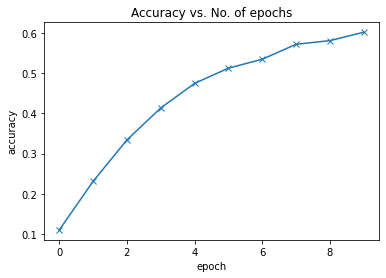

In [ ]:
plot_accuracies(history)

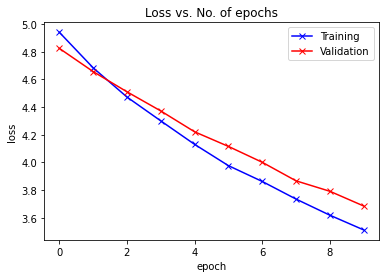

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model_efficient_b1, test_loader)

{'val_acc': 0.6015625, 'val_loss': 3.6851541996002197}

### Tuning model

In [ ]:
# Convolutional Network - Baseline
class TuningConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes, effnet=None, l1=1024):
        super().__init__()
        self.num_classes = classes
        self.features = effnet.features
        self.avgpool = effnet.avgpool
        num_ftrs = list(effnet.classifier.children())[1].in_features
        self.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                        nn.Linear(num_ftrs, l1),
                                        nn.Dropout(p=0.2, inplace=True), 
                                        nn.Linear(l1, self.num_classes))

    def forward(self,X):
        X = self.features(X)
        X = self.avgpool(X)
        X = X.view(X.size()[0], -1)
        X = self.classifier(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
def train(config, checkpoint_dir=None):
    # Tuning number of units in Linear layer
    net = TuningConvolutionalNetwork(151, efficient_b0, config["l1"])
    
    # Get device
    device = get_default_device()
    net.to(device)

    # Loss function and tuning learning rate of optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    # Tuning batch size
    train_loader = DataLoader(train_ds, 
                              batch_size=int(config["batch_size"]), 
                              shuffle=True, 
                              num_workers=2, 
                              pin_memory=True)
    val_loader = DataLoader(val_ds, 
                            batch_size=int(config["batch_size"]), 
                            num_workers=2, 
                            pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)

    # Training with tuning parameters
    for epoch in range(10):
        # Training Phase 
        net.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = net.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(net, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        net.epoch_end(epoch, result)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=result['val_loss'], accuracy=result['val_acc'])
    print("Finished Training")

In [ ]:
num_samples = 27
max_num_epochs = 20
gpus_per_trial = 1

In [ ]:
config = {
    "l1": tune.choice([256, 512, 1024]),
    "lr": tune.choice([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.choice([16, 32, 64])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    metric_columns=["val_loss", "val_accuracy", "training_iteration"])

result = tune.run(
    tune.with_parameters(train),
    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

In [ ]:
# Print result after tuning
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

Best trial config: {'l1': 512, 'lr': 0.001, 'batch_size': 64}
Best trial final validation loss: 1.552158236503601
Best trial final validation accuracy: 0.794745683670044


In [ ]:
best_trained_model = TuningConvolutionalNetwork(151, efficient_b0, 
                                                best_trial.config["l1"])
device = get_default_device()
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

# Test accuracy of best model
device = get_default_device()
test_loader = DataLoader(test_ds, 
                          batch_size=int(best_trial.config['batch_size']), 
                          num_workers=2, 
                          pin_memory=True)
test_loader = DeviceDataLoader(test_loader, device)
test_result = evaluate(best_trained_model, test_loader)
print("Best trial test set accuracy: {}".format(test_result['val_acc']))

Best trial test set accuracy: 0.794745683670044


### Training phase

#### Init best model config after tuning

In [ ]:
efficient_b0 = models.efficientnet_b0(pretrained=True)

In [ ]:
# Freeze cnn blocks
for param in efficient_b0.parameters():
    param.requires_grad = False

In [ ]:
# Load data with best batch size
batch_size = int(best_trial.config['batch_size'])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
best_model = TuningConvolutionalNetwork(151, efficient_b0, best_trial.config["l1"])

In [ ]:
history = []
num_epochs = 20
opt_func = torch.optim.Adam
lr = best_trial.config["lr"]

In [ ]:
best_model.to(device)

#### Training with freeze features block

In [ ]:
history += fit(num_epochs, lr, best_model, train_dl, val_dl, opt_func)

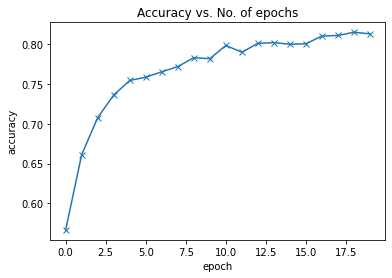

In [ ]:
plot_accuracies(history)

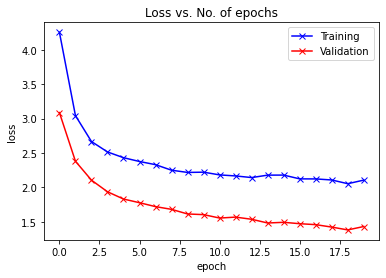

In [ ]:
plot_losses(history)

In [ ]:
evaluate(best_model, test_loader)

{'val_acc': 0.8133692145347595, 'val_loss': 1.4334062337875366}

#### Unfreeze features block and continue training

In [ ]:
# Unfreeze features blocks
for param in best_model.features.parameters():
    param.requires_grad = True

In [ ]:
unfreeze_epochs = 10

In [ ]:
history += fit(unfreeze_epochs, lr, best_model, train_dl, val_dl, opt_func)

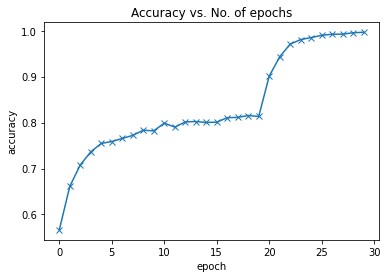

In [ ]:
plot_accuracies(history)

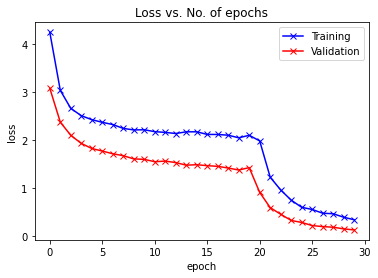

In [ ]:
plot_losses(history)

In [ ]:
evaluate(best_model, test_loader)

{'val_acc': 0.9966517686843872, 'val_loss': 0.13567619025707245}

In [ ]:
# Save model weights
torch.save(best_model.state_dict(), 'best_weights.pth')

#### Failure case

In [ ]:
best_config = {'l1': 512, 'lr': 0.001, 'batch_size': 64}

In [ ]:
batch_size = int(best_config['batch_size'])

test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
best_model = TuningConvolutionalNetwork(151, efficient_b0, best_config["l1"])

In [ ]:
best_model.load_state_dict(torch.load('best_weights.pth'))
best_model.eval()

In [ ]:
best_model.to(device)

In [ ]:
evaluate(best_model, test_loader)

In [ ]:
len(test_ds)

In [ ]:
"""
This code checks some fail cases but in top 1. 
while the accuracy calculting method is top 3
"""


failure_case = []

with torch.no_grad():
    for data in test_ds:
        image, label = data
        image_cuda = image.to(device)
        out = best_model(image_cuda.reshape(1, 3, 112, 112))
        pred = torch.max(out, 1)[1].item()
        if pred != label:
            failure_case.append((image, pred, label))

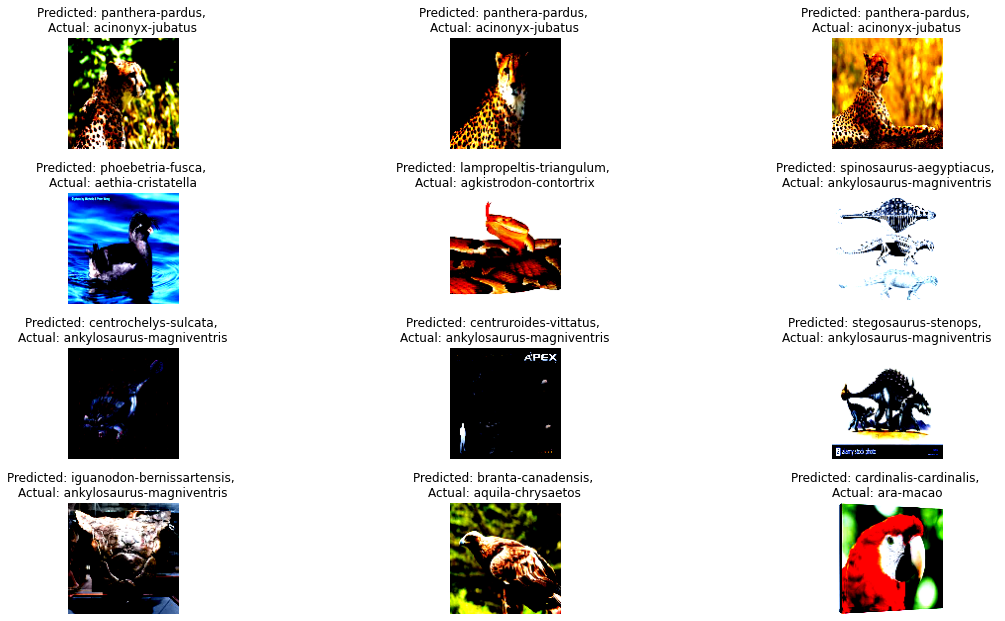

In [ ]:
fig = plt.figure(figsize=(18,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(12):
    plt.subplot(4, 3, i+1)  
    plt.axis('off')
    title = f"Predicted: {dataset.classes[failure_case[i][1]]}, \nActual: {dataset.classes[failure_case[i][2]]}"
    plt.imshow(failure_case[i][0].squeeze().permute(1,2,0))
    plt.title(title)

## FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

In [ ]:
from FLOPs_counter import print_model_parm_flops

#### VGG16

In [ ]:
# VGG16
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_vgg_flops = TF_VGG16(num_classes, vgg16)
model_vgg_flops.to(device)
print_model_parm_flops(model_vgg_flops, input.to(device), detail=False)

 + Number of FLOPs: 7.67G


#### InceptionV3

In [ ]:
# InceptionV3
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_inception_flops = TF_INCEPTIONV3(num_classes, inception_v3)
model_inception_flops.to(device)
print_model_parm_flops(model_inception_flops, input.to(device), detail=False)

 + Number of FLOPs: 1.07G


#### ResNet50

In [ ]:
# ResNet50
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_resnet_flops = TF_RESNET50(num_classes, resnet50)
model_resnet_flops.to(device)
print_model_parm_flops(model_resnet_flops, input.to(device), detail=False)

 + Number of FLOPs: 2.15G


#### EfficientNetB0

In [ ]:
# EfficientNetB0
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_eff_b0_flops = TF_EFFICIENT_NET(num_classes, efficient_b0)
model_eff_b0_flops.to(device)
print_model_parm_flops(model_eff_b0_flops, input.to(device), detail=False)

 + Number of FLOPs: 0.21G


#### EfficientNetB7

In [ ]:
# EfficientNetB7
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_eff_b7_flops = TF_EFFICIENT_NET(num_classes, efficient_b7)
model_eff_b7_flops.to(device)
print_model_parm_flops(model_eff_b7_flops, input.to(device), detail=False)

 + Number of FLOPs: 2.88G


#### EfficientNetB1

In [ ]:
# EfficientNetB1
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_eff_b1_flops = TF_EFFICIENT_NET(num_classes, efficient_b1)
model_eff_b1_flops.to(device)
print_model_parm_flops(model_eff_b1_flops, input.to(device), detail=False)

 + Number of FLOPs: 0.31G


#### Best model

In [ ]:
# Best model
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
best_model_flops = TuningConvolutionalNetwork(151, best_trained_model, best_trial.config["l1"])
best_model_flops.to(device)
print_model_parm_flops(best_model_flops, input.to(device), detail=False)

 + Number of FLOPs: 0.21G
